## Import Dependencies & System Configuration

In [1]:
import os
import time
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import inception_v3, Inception_V3_Weights

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from IPython.display import FileLink

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Computation Device: {device}")

# Random Seed for Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

[INFO] Computation Device: cuda


## Dataset Paths Configuration

In [2]:
# Original Dataset (Raw 48x48 images)
ORIGINAL_TRAIN_DIR = '/kaggle/input/facial-emotion-expressions/images/images/train'
ORIGINAL_VAL_DIR = '/kaggle/input/facial-emotion-expressions/images/images/validation'

# Processed Dataset (Upscaled 224x224 images from Preprocessing Notebook)
PROCESSED_ROOT = '/kaggle/input/emotion-processed-resnet18/processed_dataset' 
PROCESSED_TRAIN_DIR = os.path.join(PROCESSED_ROOT, 'train')
PROCESSED_VAL_DIR = os.path.join(PROCESSED_ROOT, 'validation')

## Data Distribution Analysis (Train vs Validation)

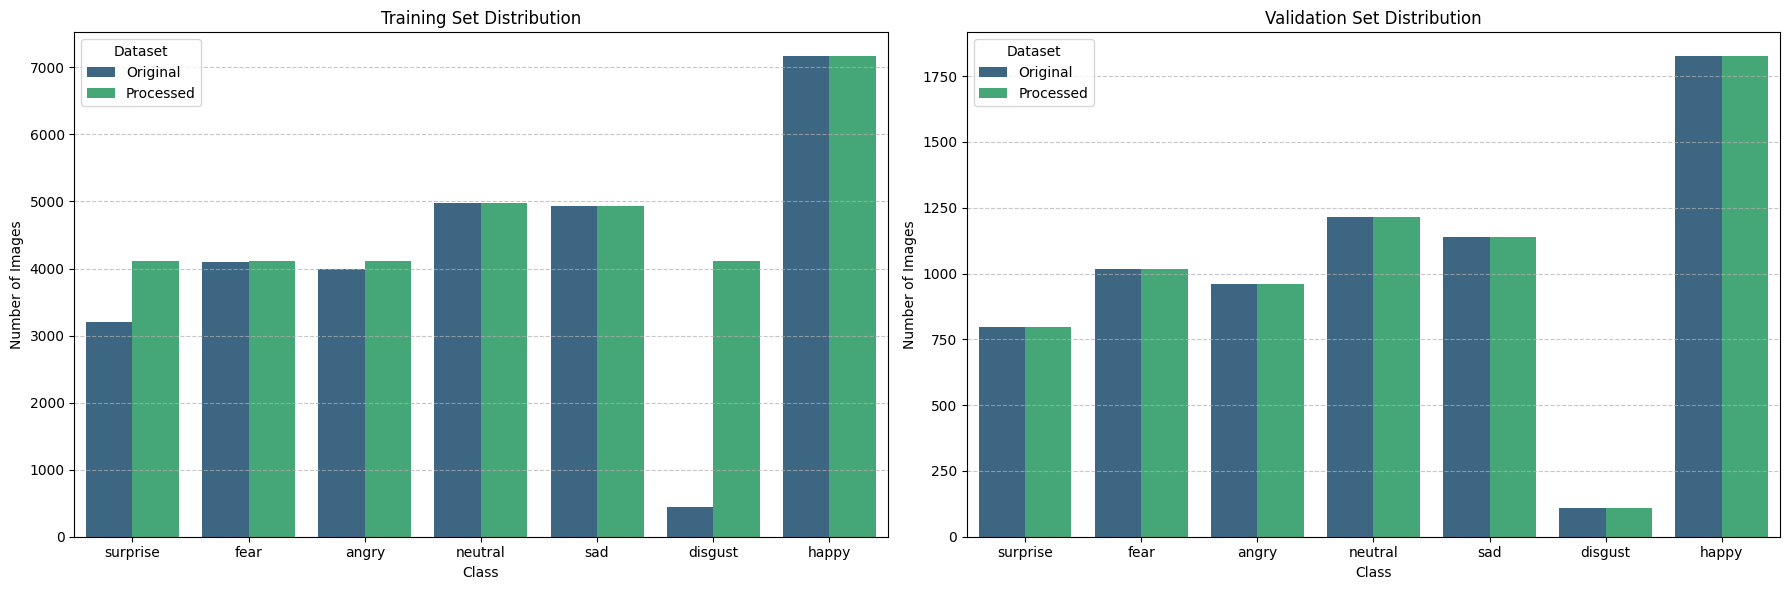

[INFO] Original Train Total: 28821
[INFO] Processed Train Total: 33552


In [3]:
def count_files(directory):
    counts = {}
    if not os.path.exists(directory):
        return counts
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Collect statistics
data_stats = []

# Training Data
orig_train = count_files(ORIGINAL_TRAIN_DIR)
proc_train = count_files(PROCESSED_TRAIN_DIR)
for cls, count in orig_train.items():
    data_stats.append({'Class': cls, 'Count': count, 'Dataset': 'Original', 'Split': 'Train'})
for cls, count in proc_train.items():
    data_stats.append({'Class': cls, 'Count': count, 'Dataset': 'Processed', 'Split': 'Train'})

# Validation Data
orig_val = count_files(ORIGINAL_VAL_DIR)
proc_val = count_files(PROCESSED_VAL_DIR)
for cls, count in orig_val.items():
    data_stats.append({'Class': cls, 'Count': count, 'Dataset': 'Original', 'Split': 'Validation'})
for cls, count in proc_val.items():
    data_stats.append({'Class': cls, 'Count': count, 'Dataset': 'Processed', 'Split': 'Validation'})

df = pd.DataFrame(data_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Training Distribution
sns.barplot(data=df[df['Split'] == 'Train'], x='Class', y='Count', hue='Dataset', palette='viridis', ax=axes[0])
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Validation Distribution
sns.barplot(data=df[df['Split'] == 'Validation'], x='Class', y='Count', hue='Dataset', palette='viridis', ax=axes[1])
axes[1].set_title('Validation Set Distribution')
axes[1].set_ylabel('Number of Images')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print Summary
print(f"[INFO] Original Train Total: {df[(df['Dataset']=='Original') & (df['Split']=='Train')]['Count'].sum()}")
print(f"[INFO] Processed Train Total: {df[(df['Dataset']=='Processed') & (df['Split']=='Train')]['Count'].sum()}")

## Data Transforms & DataLoader Factory

In [4]:
# Configuration
BATCH_SIZE = 32
NUM_WORKERS = 2
# ImageNet normalization for InceptionV3
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD  = [0.229, 0.224, 0.225]

data_transforms = {
    # Original Dataset Strategy: Heavy Augmentation
    # Justification: Small 48x48 images contain less information, requiring robustness.
    'train_orig': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.85, 1.15), shear=10),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
    ]),

    'val_orig': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),

    # Processed Dataset Strategy: Light Augmentation + Regularization
    # Justification: Images are already preprocessed (CLAHE, Upscaled). Preserve structure.
    'train_proc': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random')
    ]),

    'val_proc': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ])
}

def get_dataloaders(train_dir, val_dir, dataset_type='original'):
    """
    Factory function to create DataLoaders.
    dataset_type: 'original' (Heavy Aug) or 'processed' (Light Aug)
    """
    if dataset_type == 'processed':
        train_transform = data_transforms['train_proc']
        val_transform   = data_transforms['val_proc']
        print("[INFO] Applied augmentation strategy: LIGHT")
    else:
        train_transform = data_transforms['train_orig']
        val_transform   = data_transforms['val_orig']
        print("[INFO] Applied augmentation strategy: HEAVY")

    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True),
        'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    }

    datasets_dict = {'train': train_dataset, 'val': val_dataset}
    return datasets_dict, dataloaders

## Training Engine (Two-Stage Transfer Learning)

In [5]:
def run_epoch(model, dataloaders, criterion, optimizer, epoch_idx, dataset_sizes):
    print(f"{'Epoch':^7} | {'Phase':^7} | {'Loss':^10} | {'Acc':^10}")
    print("-" * 50)

    val_acc = 0.0
    val_loss = 0.0

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        pbar = tqdm(dataloaders[phase], leave=False, desc=f"Ep {epoch_idx+1} [{phase}]")

        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{epoch_idx+1:^7} | {phase:^7} | {epoch_loss:^10.4f} | {epoch_acc:^10.4f}")

        if phase == 'val':
            val_acc = epoch_acc.item()
            val_loss = epoch_loss

    return model, val_acc, val_loss

def train_two_stage(model, dataloaders, criterion, num_epochs_stage1=3, num_epochs_stage2=12, save_name='best_model.pth'):
    """
    Stage 1: Frozen backbone, train classifier.
    Stage 2: Fine-tune backbone with lower Learning Rate.
    """
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # --- STAGE 1 ---
    print("\n[STAGE 1] Frozen Backbone Training")
    print("=" * 60)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(num_epochs_stage1):
        model, val_acc, val_loss = run_epoch(model, dataloaders, criterion, optimizer, epoch, dataset_sizes)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    # --- STAGE 2 ---
    print("\n[STAGE 2] Full Model Fine-tuning")
    print("=" * 60)
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    for epoch in range(num_epochs_stage2):
        model, val_acc, val_loss = run_epoch(model, dataloaders, criterion, optimizer, epoch + num_epochs_stage1, dataset_sizes)
        scheduler.step(val_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_name)

    print(f"\n[RESULT] Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

## Model Initialization & Loss Functions

In [6]:
def initialize_inception_model(num_classes):
    """
    Initializes InceptionV3, handles AuxLogits, and modifies the final layer.
    """
    model = inception_v3(pretrained=True, aux_logits=True)
    # Disable auxiliary classifier after loading weights to simplify training
    model.aux_logits = False
    model.AuxLogits = None

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.BatchNorm1d(num_ftrs),
        nn.Dropout(0.7),
        nn.Linear(num_ftrs, num_classes)
    )
    return model.to(device)

# --- Loss Function Configuration ---

# 1. Original Dataset: Weighted CrossEntropy
# Used to handle class imbalance in the raw data.
print("[INFO] Computing class weights for ORIGINAL dataset...")
temp_dataset = datasets.ImageFolder(ORIGINAL_TRAIN_DIR)
targets = temp_dataset.targets
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion_weighted = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.0)
print(f"[INFO] Weighted Loss initialized. Weights: {class_weights}")

# 2. Processed Dataset: CrossEntropy with Label Smoothing
# Used since data is already balanced; smoothing helps prevent overfitting.
criterion_unweighted = nn.CrossEntropyLoss(label_smoothing=0.1)
print("[INFO] Label Smoothing Loss initialized for Processed dataset.")

[INFO] Computing class weights for ORIGINAL dataset...
[INFO] Weighted Loss initialized. Weights: [1.0311259  9.44331586 1.00348177 0.57471883 0.8264323  0.83379622
 1.28464453]
[INFO] Label Smoothing Loss initialized for Processed dataset.


## Experiment A: Original Dataset Training

In [7]:
print("\n" + "="*60)
print("EXPERIMENT A: ORIGINAL DATASET (Heavy Augmentation + Weighted Loss)")
print("="*60)

# 1. Load Data
dsets_orig, loaders_orig = get_dataloaders(ORIGINAL_TRAIN_DIR, ORIGINAL_VAL_DIR, dataset_type='original')
class_names = dsets_orig['train'].classes

# 2. Initialize Model
model_orig = initialize_inception_model(len(class_names))

# 3. Train
model_orig, hist_orig = train_two_stage(
    model_orig, 
    loaders_orig, 
    criterion_weighted, 
    num_epochs_stage1=3, 
    num_epochs_stage2=12, 
    save_name='best_model_original.pth'
)


EXPERIMENT A: ORIGINAL DATASET (Heavy Augmentation + Weighted Loss)
[INFO] Applied augmentation strategy: HEAVY


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 230MB/s] 



[STAGE 1] Frozen Backbone Training
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 1 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   1    |  train  |   2.3600   |   0.1895  


Ep 1 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   1    |   val   |   1.8057   |   0.2308  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 2 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   2    |  train  |   2.3419   |   0.2012  


Ep 2 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   2    |   val   |   1.8368   |   0.2339  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 3 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   3    |  train  |   2.3236   |   0.1989  


Ep 3 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   3    |   val   |   1.9419   |   0.1878  

[STAGE 2] Full Model Fine-tuning
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Ep 4 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   4    |  train  |   1.7963   |   0.3484  


Ep 4 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   4    |   val   |   1.3033   |   0.5024  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 5 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   5    |  train  |   1.3927   |   0.4806  


Ep 5 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   5    |   val   |   1.0820   |   0.5894  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 6 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   6    |  train  |   1.2551   |   0.5288  


Ep 6 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   6    |   val   |   1.0245   |   0.6187  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 7 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   7    |  train  |   1.1455   |   0.5707  


Ep 7 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   7    |   val   |   1.0121   |   0.6267  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 8 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   8    |  train  |   1.0878   |   0.5917  


Ep 8 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   8    |   val   |   0.9300   |   0.6538  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 9 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

   9    |  train  |   1.0097   |   0.6219  


Ep 9 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   9    |   val   |   0.9180   |   0.6657  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 10 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

  10    |  train  |   0.9533   |   0.6419  


Ep 10 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  10    |   val   |   0.9984   |   0.6493  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 11 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

  11    |  train  |   0.9299   |   0.6460  


Ep 11 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  11    |   val   |   0.9227   |   0.6642  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 12 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

  12    |  train  |   0.8742   |   0.6644  


Ep 12 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  12    |   val   |   0.9222   |   0.6810  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 13 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

  13    |  train  |   0.8705   |   0.6695  


Ep 13 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  13    |   val   |   0.8958   |   0.6871  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 14 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

  14    |  train  |   0.8313   |   0.6839  


Ep 14 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  14    |   val   |   0.9004   |   0.6728  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 15 [train]:   0%|          | 0/901 [00:00<?, ?it/s]

  15    |  train  |   0.7891   |   0.6984  


Ep 15 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  15    |   val   |   0.9135   |   0.6786  

[RESULT] Best Validation Accuracy: 0.6871


## Experiment B: Processed Dataset Training

In [8]:
print("\n" + "="*60)
print("EXPERIMENT B: PROCESSED DATASET (Light Augmentation + No Weights)")
print("="*60)

# 1. Load Data
dsets_proc, loaders_proc = get_dataloaders(PROCESSED_TRAIN_DIR, PROCESSED_VAL_DIR, dataset_type='processed')

# 2. Initialize New Model
model_proc = initialize_inception_model(len(class_names))

# 3. Train
# Note: Unweighted criterion used as data was balanced during preprocessing (Notebook 1).
model_proc, hist_proc = train_two_stage(
    model_proc, 
    loaders_proc, 
    criterion_unweighted,
    num_epochs_stage1=3, 
    num_epochs_stage2=12, 
    save_name='best_model_processed.pth'
)


EXPERIMENT B: PROCESSED DATASET (Light Augmentation + No Weights)
[INFO] Applied augmentation strategy: LIGHT

[STAGE 1] Frozen Backbone Training
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 1 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   1    |  train  |   2.2000   |   0.2189  


Ep 1 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   1    |   val   |   1.7299   |   0.3583  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 2 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   2    |  train  |   2.1244   |   0.2341  


Ep 2 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   2    |   val   |   1.7245   |   0.3715  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 3 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   3    |  train  |   2.0775   |   0.2350  


Ep 3 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   3    |   val   |   1.7294   |   0.3647  

[STAGE 2] Full Model Fine-tuning
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 4 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   4    |  train  |   1.4978   |   0.5113  


Ep 4 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   4    |   val   |   1.2362   |   0.6159  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 5 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   5    |  train  |   1.1925   |   0.6556  


Ep 5 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   5    |   val   |   1.1726   |   0.6612  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 6 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   6    |  train  |   1.0742   |   0.7126  


Ep 6 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   6    |   val   |   1.1686   |   0.6612  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 7 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   7    |  train  |   0.9953   |   0.7505  


Ep 7 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   7    |   val   |   1.1390   |   0.6753  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 8 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   8    |  train  |   0.9121   |   0.7943  


Ep 8 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   8    |   val   |   1.1453   |   0.6780  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 9 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

   9    |  train  |   0.8520   |   0.8217  


Ep 9 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

   9    |   val   |   1.1563   |   0.6768  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 10 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

  10    |  train  |   0.7812   |   0.8552  


Ep 10 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  10    |   val   |   1.1877   |   0.6722  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 11 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

  11    |  train  |   0.7285   |   0.8828  


Ep 11 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  11    |   val   |   1.2176   |   0.6708  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 12 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

  12    |  train  |   0.6184   |   0.9358  


Ep 12 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  12    |   val   |   1.2089   |   0.6990  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 13 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

  13    |  train  |   0.5722   |   0.9572  


Ep 13 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  13    |   val   |   1.2132   |   0.6984  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 14 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

  14    |  train  |   0.5507   |   0.9666  


Ep 14 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  14    |   val   |   1.2648   |   0.6817  
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


Ep 15 [train]:   0%|          | 0/1049 [00:00<?, ?it/s]

  15    |  train  |   0.5383   |   0.9715  


Ep 15 [val]:   0%|          | 0/221 [00:00<?, ?it/s]

  15    |   val   |   1.2844   |   0.6888  

[RESULT] Best Validation Accuracy: 0.6990


## Training History Analysis (Original vs. Processed)

Generating comparative training curves...


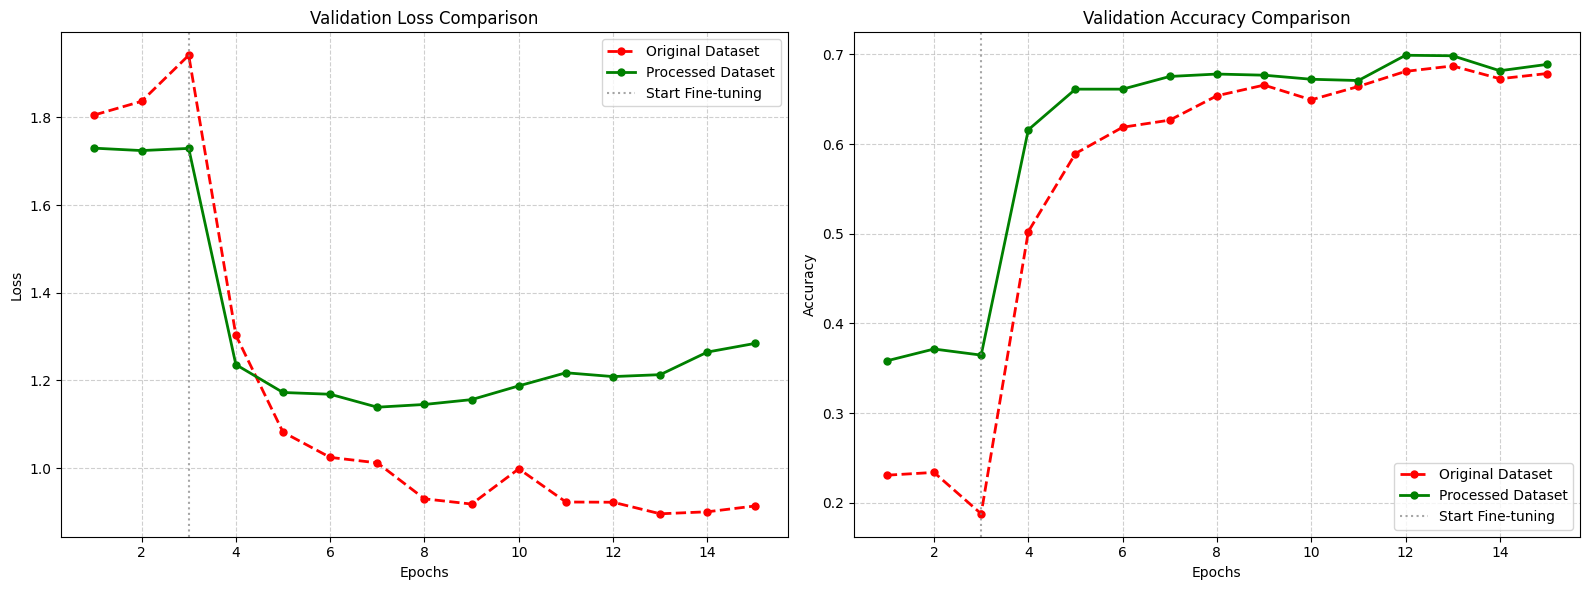

In [9]:
def plot_training_comparison(hist_orig, hist_proc, stage1_epochs=3):
    """
    Plots the comparison of Validation Loss and Accuracy between 
    the Original and Processed datasets over epochs.
    """
    epochs_orig = range(1, len(hist_orig['val_acc']) + 1)
    epochs_proc = range(1, len(hist_proc['val_acc']) + 1)

    plt.figure(figsize=(16, 6))

    # --- Subplot 1: Validation Loss Comparison ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_orig, hist_orig['val_loss'], 'r--o', label='Original Dataset', linewidth=2, markersize=5)
    plt.plot(epochs_proc, hist_proc['val_loss'], 'g-o', label='Processed Dataset', linewidth=2, markersize=5)
    
    # Visual marker for Fine-tuning start
    plt.axvline(x=stage1_epochs, color='gray', linestyle=':', alpha=0.7, label='Start Fine-tuning')
    
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- Subplot 2: Validation Accuracy Comparison ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_orig, hist_orig['val_acc'], 'r--o', label='Original Dataset', linewidth=2, markersize=5)
    plt.plot(epochs_proc, hist_proc['val_acc'], 'g-o', label='Processed Dataset', linewidth=2, markersize=5)
    
    # Visual marker for Fine-tuning start
    plt.axvline(x=stage1_epochs, color='gray', linestyle=':', alpha=0.7, label='Start Fine-tuning')
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Execute Plotting
print("Generating comparative training curves...")
plot_training_comparison(hist_orig, hist_proc, stage1_epochs=3)

## Comparative Evaluation & Visualization

DETAILED EVALUATION
Evaluating Original Model...


Eval Original:   0%|          | 0/221 [00:00<?, ?it/s]

Evaluating Processed Model...


Eval Processed:   0%|          | 0/221 [00:00<?, ?it/s]


############################################################
          CLASSIFICATION REPORT: ORIGINAL DATASET           
############################################################
              precision    recall  f1-score   support

       angry     0.5732    0.6854    0.6243       960
     disgust     0.5956    0.7297    0.6559       111
        fear     0.5903    0.4656    0.5206      1018
       happy     0.9099    0.8521    0.8800      1825
     neutral     0.5857    0.7418    0.6546      1216
         sad     0.6065    0.4723    0.5311      1139
    surprise     0.7675    0.8118    0.7890       797

    accuracy                         0.6871      7066
   macro avg     0.6612    0.6798    0.6651      7066
weighted avg     0.6924    0.6871    0.6847      7066


############################################################
          CLASSIFICATION REPORT: PROCESSED DATASET          
############################################################
              precision    recall  

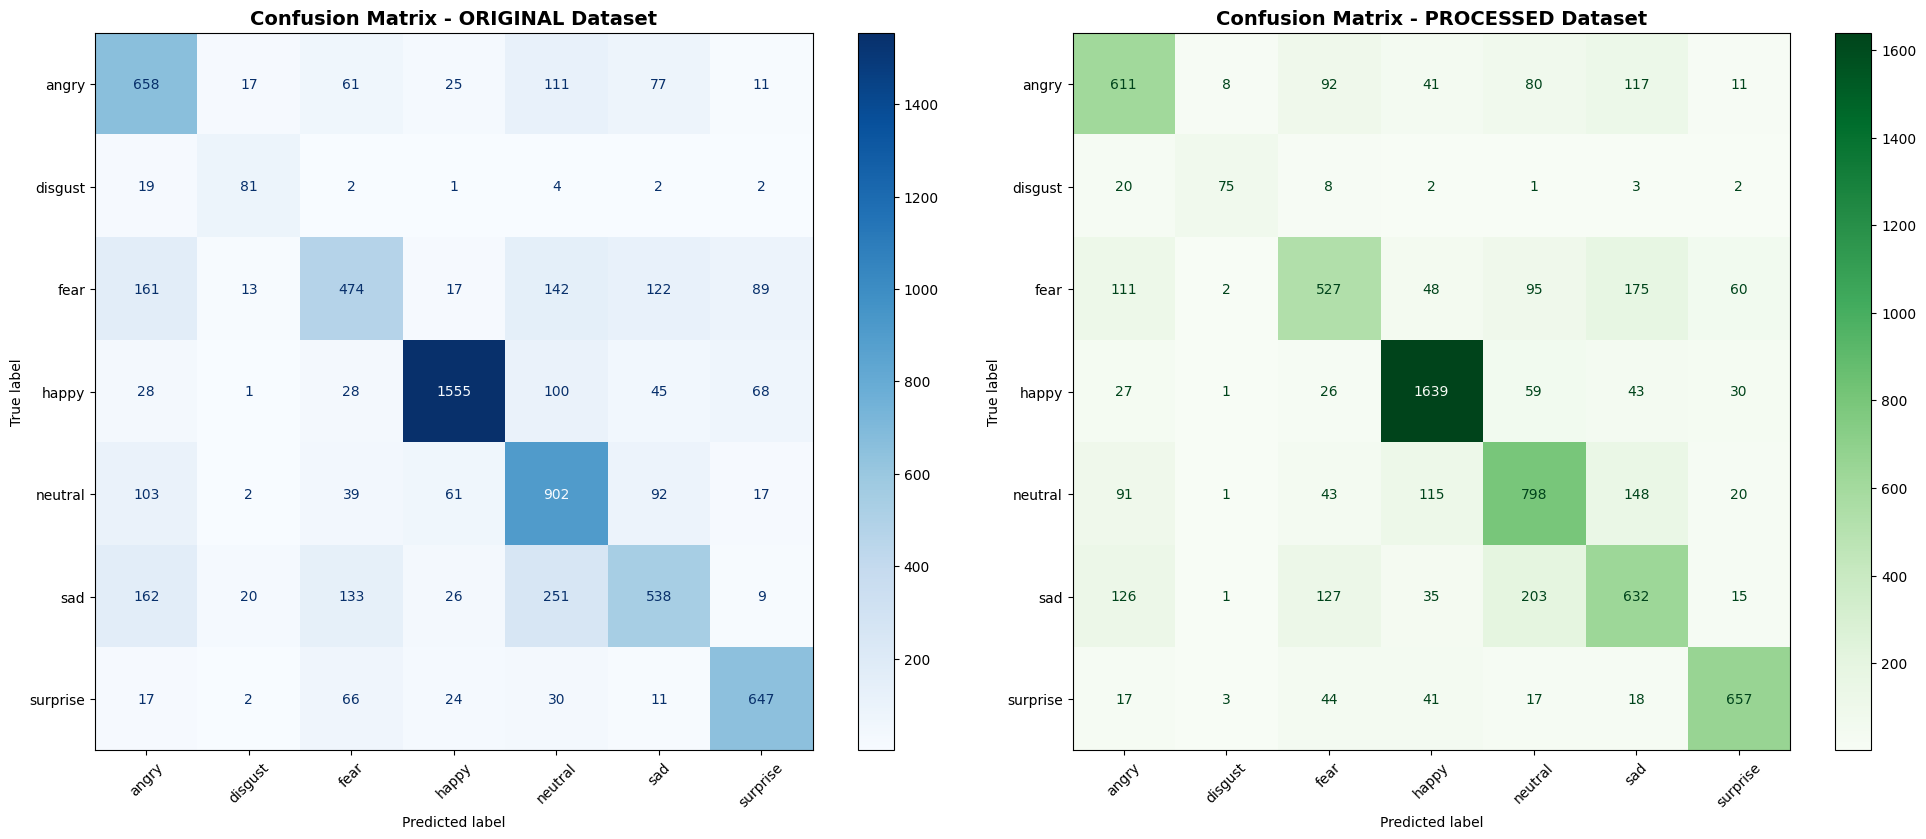

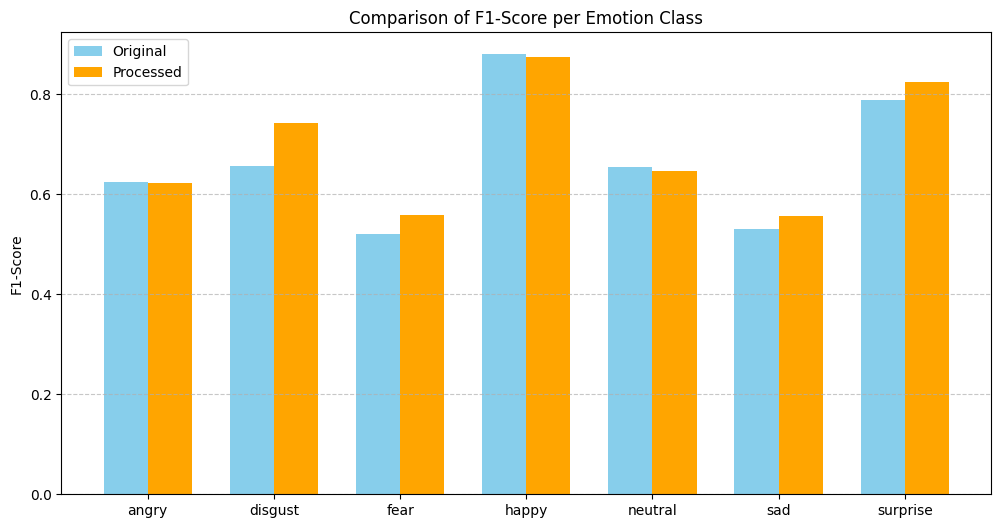

[CONCLUSION] Weighted F1-Score Improvement: 0.6847 -> 0.6967 (Change: 1.20%)


In [10]:
def evaluate_model_detailed(model, dataloader, dataset_name="Original"):
    model.eval()
    y_true = []
    y_pred = []
    
    print(f"Evaluating {dataset_name} Model...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False, desc=f"Eval {dataset_name}"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    return np.array(y_true), np.array(y_pred)

print("="*60)
print("DETAILED EVALUATION")
print("="*60)

# Run Inference
y_true_orig, y_pred_orig = evaluate_model_detailed(model_orig, loaders_orig['val'], "Original")
y_true_proc, y_pred_proc = evaluate_model_detailed(model_proc, loaders_proc['val'], "Processed")

# 1. Classification Reports
print("\n" + "#"*60)
print(f"{'CLASSIFICATION REPORT: ORIGINAL DATASET':^60}")
print("#"*60)
print(classification_report(y_true_orig, y_pred_orig, target_names=class_names, digits=4))

print("\n" + "#"*60)
print(f"{'CLASSIFICATION REPORT: PROCESSED DATASET':^60}")
print("#"*60)
print(classification_report(y_true_proc, y_pred_proc, target_names=class_names, digits=4))

# 2. Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

cm_orig = confusion_matrix(y_true_orig, y_pred_orig)
disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig, display_labels=class_names)
disp_orig.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - ORIGINAL Dataset', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

cm_proc = confusion_matrix(y_true_proc, y_pred_proc)
disp_proc = ConfusionMatrixDisplay(confusion_matrix=cm_proc, display_labels=class_names)
disp_proc.plot(ax=axes[1], cmap='Greens', values_format='d') 
axes[1].set_title('Confusion Matrix - PROCESSED Dataset', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. F1-Score Comparison
f1_orig = f1_score(y_true_orig, y_pred_orig, average=None)
f1_proc = f1_score(y_true_proc, y_pred_proc, average=None)
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, f1_orig, width, label='Original', color='skyblue')
plt.bar(x + width/2, f1_proc, width, label='Processed', color='orange')
plt.ylabel('F1-Score')
plt.title('Comparison of F1-Score per Emotion Class')
plt.xticks(x, class_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Final Metric
avg_orig = f1_score(y_true_orig, y_pred_orig, average='weighted')
avg_proc = f1_score(y_true_proc, y_pred_proc, average='weighted')
print(f"[CONCLUSION] Weighted F1-Score Improvement: {avg_orig:.4f} -> {avg_proc:.4f} (Change: {(avg_proc - avg_orig)*100:.2f}%)")

## Export Models & Artifacts

In [11]:
# Save Class Mapping
class_mapping = {i: name for i, name in enumerate(class_names)}
with open('class_indices.json', 'w') as f:
    json.dump(class_mapping, f)
    print("[INFO] Saved class mapping to 'class_indices.json'")

# Download Links
print("\n[INFO] Generated Download Links:")
display(FileLink(r'best_model_original.pth'))
display(FileLink(r'best_model_processed.pth'))
display(FileLink(r'class_indices.json'))

[INFO] Saved class mapping to 'class_indices.json'

[INFO] Generated Download Links:


/kaggle/working/best_model_original.pth

/kaggle/working/best_model_processed.pth

/kaggle/working/class_indices.json